# Bond Dimension Required vs. Number of Nodes

In [2]:
include("../funcs/adjacency.jl")  
include("../funcs/mps.jl")  
include("../funcs/hamiltonian.jl")

solve_xxz_hamiltonian_dmrg (generic function with 4 methods)

## Params

In [ ]:
num_graphs_to_avg = 10 # number of graphs to average over for each (N, σ) pair
N_vals = 10:2:100 # number of nodes to test
σ_vals = [0.0, 0.001, 0.002] # sigma values to test for the adjacency martrix

J = 1.0 # interaction strength
Δ = 1.5 # anisotropy parameter




# Generate MPOs

In [ ]:

data = nothing

In [ ]:
using ITensorMPS, ITensors
using ProgressMeter
import Statistics

if data == nothing
    data = Dict() # {σ => {N => (max_bond_dim, error)}}

    total_iterations = length(N_vals) * length(σ_vals)
    progress = Progress(total_iterations, desc="Calculating bond dimensions")

    for N in N_vals
        for σ in σ_vals
            local_averaging = σ != 0.0 ? num_graphs_to_avg : 1 # only bother averaging if we actually have randomness

            bond_dims = Int[]
            for _ in 1:local_averaging
                wam = generate_fully_connected_wam(N, σ) # weighted adjacency matrix
                ψ_mps, sites = create_MPS(N)
                H = create_xxz_hamiltonian_mpo(N, wam, J, Δ, sites)
                max_bond_dim = maxlinkdim(H) # maximum bond dimension of the MPO hamiltonian
                push!(bond_dims, max_bond_dim)
            end

            avg_bond_dim = Statistics.mean(bond_dims) # average over local_averaging graphs
            error = σ != 0.0 ? Statistics.std(bond_dims) : 0 # standard deviation if we have randomness, else 0

            # create the sigma key if it doesn't exist
            if !haskey(data, σ)
                data[σ] = Dict()
            end
            data[σ][N] = (avg_bond_dim, error)

            next!(progress)
        end
    end
end

In [ ]:
# save the data in json format
using JLD2
jldsave("../data/bond_dim_vs_nodes_data.jld2", data)

In [ ]:
# plot the data using plots
using Plots

σ_to_plot = [0.0, 0.002]

# we should have all the sigma values on the same plot, we want avg_bond_dim vs N with error bars
colors = [:red, :blue, :green, :orange, :purple]
plt = plot(title="Maximum Bond Dimension vs Number of Nodes \n (averaged over $num_graphs_to_avg graphs)",
    xlabel="Number of Nodes (N)",
    ylabel="Maximum Bond Dimension",
    legend=:topleft)

for (i, σ) in enumerate(keys(data))
    if !(σ in σ_to_plot)
        continue
    end
    σ_data = data[σ]
    N_vals = collect(keys(σ_data))
    avg_bond_dims = [σ_data[N][1] for N in N_vals]
    errors = [σ_data[N][2] for N in N_vals]

    plot!(plt, N_vals, avg_bond_dims, 
          yerror=errors,
          label="σ = $σ", 
          color=colors[i % length(colors) + 1],
          marker=:circle,
          markersize=3,
          linewidth=2)
end
savefig(plt, "../assets/graphs/bond_dim_req_vs_nodes_ham_mpo.png")
display(plt)

# Same thing, but for Ground State MPS at sigma=0.0

In [7]:
# new parameters
N_vals = 10:1:75 # number of nodes to test
σ_vals = [0.0, 0.001, 0.002] # sigma values to test for the adjacency martrix

num_graphs_to_avg = 1 # number of graphs to average over for each (N, σ) pair
max_bond_dim = 1000 # maximum bond dimension for the MPS

# Hamiltonian parameters - Heisenberg XXZ
J = -1 # interaction strength
Δ = -1 # anisotropy parameter

RERUN = true

true

In [ ]:
# attempt to load data first 
using JLD2
data_gs_mps = load("../data/bond_dim_vs_nodes_gs_mps_avg_5.jld2", "data_gs_mps")

In [8]:
data_gs_mps = nothing

In [ ]:
using Pkg
println("Active project: ", Pkg.project().path)
println("Julia threads: ", Threads.nthreads())
println("CPU cores: ", Sys.CPU_THREADS)

In [9]:

using Base.Threads
import Statistics
using ITensorMPS, ITensors
using ProgressMeter
using Random

if data_gs_mps == nothing || RERUN


    println("Using $(Threads.nthreads()) threads for parallel computation.")
    N_results = Vector{Any}(undef, length(N_vals))

    shuffled_N_indices = shuffle(1:length(N_vals))
    
    completed = Threads.Atomic{Int}(0)
    total_tasks = length(N_vals)

    @threads for i in 1:length(N_vals)
        n_idx = shuffled_N_indices[i]  # Get the shuffled index
        N = N_vals[n_idx]  # Use the shuffled index to get N
        
        println("Thread $(Threads.threadid()) starting N = $N (index $n_idx)")
        N_data = Dict()
        N_data = Dict()
        
        for σ in σ_vals
            local_averaging = σ != 0.0 ? num_graphs_to_avg : 1
            bond_dims = Int[]
            
            for _ in 1:local_averaging
                wam = generate_fully_connected_wam(N, σ)
                ψ_mps, sites = create_MPS(N)
                H = create_xxz_hamiltonian_mpo(N, wam, J, Δ, sites)
                energy, ψ_gs = solve_xxz_hamiltonian_dmrg(H, ψ_mps, 10, max_bond_dim, 1e-10)
                bond_dim = maxlinkdim(ψ_gs)
                push!(bond_dims, bond_dim)
            end
            
            avg_bond_dim = Statistics.mean(bond_dims)
            # standard error on the mean
            if σ != 0.0
                error = Statistics.std(bond_dims) / sqrt(length(bond_dims)) # std/sqrt(sample size)
            else
                error = 0.0
            end
            N_data[σ] = (avg_bond_dim, error)
        end
        
        Threads.atomic_add!(completed, 1)

        N_results[n_idx] = (N, N_data)
        println("Completed N = $N on thread $(Threads.threadid()). Progress: $(completed[]) / $total_tasks")
    end
    
    data_gs_mps = Dict() # {σ => {N => (max_bond_dim, error)}}
    # Combine results
    for (N, N_data) in N_results
        for (σ, values) in N_data
            if !haskey(data_gs_mps, σ)
                data_gs_mps[σ] = Dict()
            end
            data_gs_mps[σ][N] = values
        end
    end
end

Using 8 threads for parallel computation.
Thread 1 starting N = 48 (index 39)
Thread 5 starting N = 54 (index 45)
Thread 4 starting N = 36 (index 27)
Thread 3 starting N = 28 (index 19)
Thread 2 starting N = 15 (index 6)
Thread 8 starting N = 39 (index 30)
Thread 6 starting N = 33 (index 24)
Thread 7 starting N = 31 (index 22)
Completed N = 15 on thread 8. Progress: 1 / 66
Thread 8 starting N = 68 (index 59)
Completed N = 28 on thread 3. Progress: 2 / 66
Thread 3 starting N = 56 (index 47)
Completed N = 31 on thread 1. Progress: 3 / 66
Thread 1 starting N = 18 (index 9)
Completed N = 33 on thread 7. Progress: 4 / 66
Thread 7 starting N = 58 (index 49)
Completed N = 36 on thread 4. Progress: 5 / 66
Thread 4 starting N = 71 (index 62)
Completed N = 18 on thread 1. Progress: 6 / 66
Thread 1 starting N = 52 (index 43)
Completed N = 39 on thread 2. Progress: 7 / 66
Thread 2 starting N = 67 (index 58)
Completed N = 48 on thread 6. Progress: 8 / 66
Thread 6 starting N = 26 (index 17)
Complete

In [10]:
using JLD2
    
# Save data
jldsave("../data/bond_dim_vs_nodes_gs_mps_lower_sweeps.jld2"; data_gs_mps)

Dict{Any, Any} with 3 entries:
  0.0   => Dict{Any, Any}(56=>(21.0, 0.0), 35=>(18.0, 0.0), 55=>(21.0, 0.0), 60…
  0.002 => Dict{Any, Any}(56=>(61.0, NaN), 35=>(88.0, NaN), 55=>(65.0, NaN), 60…
  0.001 => Dict{Any, Any}(56=>(24.0, NaN), 35=>(49.0, NaN), 55=>(23.0, NaN), 60…

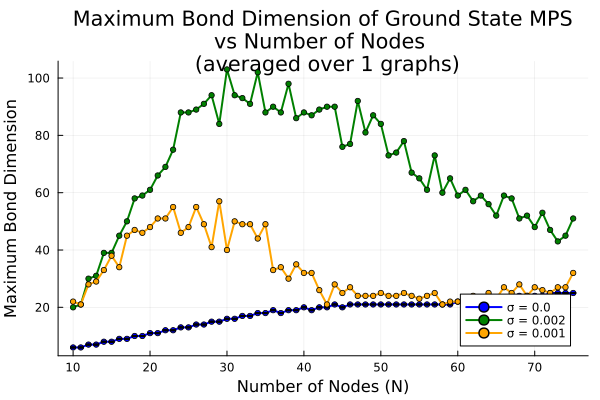

In [11]:
# then plot the data
using Plots

display(data_gs_mps)

σ_to_plot = [0.0, 0.001, 0.002]
colors = [:red, :blue, :green, :orange, :purple]
plt = plot(title="Maximum Bond Dimension of Ground State MPS
vs Number of Nodes \n (averaged over $num_graphs_to_avg graphs)",
    xlabel="Number of Nodes (N)",
    ylabel="Maximum Bond Dimension",
    legend=:bottomright)

for (i, σ) in enumerate(keys(data_gs_mps))
    if !(σ in σ_to_plot)
        continue
    end
    σ_data = data_gs_mps[σ]
    N_vals = collect(keys(σ_data))
    N_vals_sorted = sort(N_vals)
    avg_bond_dims = [σ_data[N][1] for N in N_vals_sorted]
    errors = [σ_data[N][2] for N in N_vals_sorted] # should be 0 for σ=0

    plot!(plt, N_vals_sorted, avg_bond_dims,
          yerror=errors,
          label="σ = $σ", 
          color=colors[i % length(colors) + 1],
          marker=:circle,
          markersize=3,
          linewidth=2)
end
savefig(plt, "../assets/graphs/bond_dim_vs_nodes_lower_sweeps.png")
display(plt)    